In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Treino + ranking de CVAE para modelagem de canal VLC
====================================================

• Autor:  <seu_nome>
• Data :  <yyyy-mm-dd>
"""

# ────────────────────────────────────────────────────────────────────────
# 0)  IMPORTS & BACKEND
# ────────────────────────────────────────────────────────────────────────
import os
import time
import itertools
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from scipy import stats
import matplotlib.pyplot as plt

# GPU/CPU backend setup
try:
    import cupy as cp
    xp, gpu_enabled = cp, True
    print("CuPy (GPU) backend ativado.")
except ImportError:
    xp, gpu_enabled = np, False
    print("NumPy (CPU) backend ativado.")

# Reproducibilidade
np.random.seed(42)
tf.random.set_seed(42)
if gpu_enabled:
    cp.random.seed(42)

# ────────────────────────────────────────────────────────────────────────
# 1)  CARREGAMENTO E PREPARAÇÃO DOS DADOS
# ────────────────────────────────────────────────────────────────────────
print("Carregando dados...")
base_path = "/workspace/1-Dataset(GNU_RADIO)/FULLSQUARE/IQ_data"

# Verificação dos arquivos
for fname in ["sent_data_tuple.npy", "received_data_tuple_sync-phase.npy"]:
    fpath = os.path.join(base_path, fname)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Arquivo não encontrado: {fpath}")
    print(f"Arquivo localizado: {fpath}")

# Carregamento dos dados
X = np.load(os.path.join(base_path, "sent_data_tuple.npy"))
Y = np.load(os.path.join(base_path, "received_data_tuple_sync-phase.npy"))

print(f"Dados carregados - X: {X.shape}, Y: {Y.shape}")

# Embaralhamento e divisão
idx = np.arange(len(X))
np.random.shuffle(idx)
X, Y = X[idx], Y[idx]

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

print(f"Divisão - Train: X{X_train.shape}, Y{Y_train.shape}")
print(f"         Test:  X{X_test.shape}, Y{Y_test.shape}")

# ────────────────────────────────────────────────────────────────────────
# 2)  FUNÇÕES DE MÉTRICA
# ────────────────────────────────────────────────────────────────────────

def safe_log10(x, eps=1e-12):
    """Log10 seguro com epsilon para evitar log(0)"""
    return xp.log10(xp.maximum(x, eps))

def safe_log2(x, eps=1e-12):
    """Log2 seguro com epsilon para evitar log(0)"""
    return xp.log2(xp.maximum(x, eps))

def calculate_evm(ref, test):
    """Calcula EVM (Error Vector Magnitude)"""
    ref, test = xp.asarray(ref), xp.asarray(test)
    rc = ref[:,0] + 1j * ref[:,1]
    tc = test[:,0] + 1j * test[:,1]
    
    mean_power = xp.mean(xp.abs(rc)**2)
    if mean_power == 0:
        return float('inf'), float('-inf')
    
    err = tc - rc
    evm_val = xp.sqrt(xp.mean(xp.abs(err)**2) / mean_power)
    evm_pct = float(evm_val * 100)
    evm_db = float(20 * safe_log10(evm_val))
    
    return evm_pct, evm_db

def calculate_snr(ref, test):
    """Calcula SNR (Signal-to-Noise Ratio)"""
    ref, test = xp.asarray(ref), xp.asarray(test)
    rc = ref[:,0] + 1j * ref[:,1]
    tc = test[:,0] + 1j * test[:,1]
    
    noise = rc - tc
    signal_power = xp.mean(xp.abs(rc)**2)
    noise_power = xp.mean(xp.abs(noise)**2)
    
    if noise_power == 0:
        return float('inf') if signal_power > 0 else 0.0
    
    snr_val = signal_power / noise_power
    return float(10 * safe_log10(snr_val))

def calculate_psnr(mse, peak=1.0):
    """Calcula PSNR (Peak Signal-to-Noise Ratio)"""
    if mse <= 0:
        return float('inf') if mse == 0 else float('-inf')
    return float(20 * np.log10(peak) - 10 * np.log10(mse))

def calculate_noise_power(sent, recv):
    """Calcula potência do ruído"""
    sent, recv = xp.asarray(sent), xp.asarray(recv)
    noise = recv - sent
    return float(xp.mean(xp.sum(noise**2, axis=1)))

def compute_basic_metrics(x, y):
    """Calcula métricas básicas (MSE, RMSE, MAE, correlação)"""
    x_gpu, y_gpu = xp.asarray(x), xp.asarray(y)
    err = x_gpu - y_gpu
    
    # MSE e RMSE
    mse = float(xp.mean(xp.sum(err**2, axis=1)))
    rmse = float(xp.sqrt(mse))
    
    # MAE
    mae = float(xp.mean(xp.linalg.norm(err, axis=1)))
    
    # Similaridade cosseno
    norm_x = xp.linalg.norm(x_gpu.ravel())
    norm_y = xp.linalg.norm(y_gpu.ravel())
    if norm_x == 0 or norm_y == 0:
        cos = 0.0
    else:
        cos = float(xp.dot(x_gpu.ravel(), y_gpu.ravel()) / (norm_x * norm_y))
    
    # Correlação (na CPU)
    x_cpu = cp.asnumpy(x_gpu) if gpu_enabled else x_gpu
    y_cpu = cp.asnumpy(y_gpu) if gpu_enabled else y_gpu
    
    if len(x_cpu.ravel()) < 2 or len(y_cpu.ravel()) < 2:
        corr = 0.0
    else:
        try:
            corr_matrix = np.corrcoef(x_cpu.ravel(), y_cpu.ravel())
            corr = float(corr_matrix[0,1]) if corr_matrix.ndim == 2 else 0.0
        except:
            corr = 0.0
    
    return mse, rmse, mae, cos, corr

# --- KDE-based JSD / KL (GPU-ready) ---
def _kde_gpu(data, positions, bw=0.1, batch_size=2000):
    """Estimação de densidade por kernel na GPU"""
    data = xp.asarray(data)
    val = xp.zeros(positions.shape[0], dtype=xp.float32)
    num_points = len(data)
    
    if num_points == 0:
        return val
    
    for i in range(0, num_points, batch_size):
        batch_data = data[i:i+batch_size]
        exp_term = -0.5 * (((batch_data[:,0,None] - positions[:,0])/bw)**2 +
                          ((batch_data[:,1,None] - positions[:,1])/bw)**2)
        val += xp.sum(xp.exp(exp_term), axis=0)
    
    val /= num_points
    val /= (2 * np.pi * bw**2)  # Normalização Gaussiana
    
    sum_val = xp.sum(val)
    if sum_val > 0:
        val /= sum_val
    
    return val

def _prep_grid(grid_res=100, data_min=-1.5, data_max=1.5):
    """Prepara grade para estimação de densidade"""
    xi = xp.linspace(data_min, data_max, grid_res)
    X_grid, Y_grid = xp.meshgrid(xi, xi)
    return xp.stack([X_grid.ravel(), Y_grid.ravel()], axis=1)

def calculate_jsd_gpu(real, pred, grid_res=100, bw=0.1):
    """Calcula Jensen-Shannon Divergence"""
    pos = _prep_grid(grid_res)
    P = _kde_gpu(real, pos, bw)
    Q = _kde_gpu(pred, pos, bw)
    M = 0.5 * (P + Q)
    
    eps = 1e-12
    jsd = 0.5 * xp.sum(xp.where(P > eps, P * safe_log2(P / (M + eps)), 0)) + \
          0.5 * xp.sum(xp.where(Q > eps, Q * safe_log2(Q / (M + eps)), 0))
    
    return float(jsd)

def calculate_kl_gpu(real, pred, grid_res=100, bw=0.1):
    """Calcula Kullback-Leibler Divergence"""
    pos = _prep_grid(grid_res)
    P = _kde_gpu(real, pos, bw)
    Q = _kde_gpu(pred, pos, bw)
    
    eps = 1e-12
    kl_val = xp.sum(xp.where(P > eps, P * xp.log((P + eps) / (Q + eps)), 0))
    
    return float(kl_val)

def calculate_ks_test(data1, data2):
    """Calcula teste Kolmogorov-Smirnov"""
    if gpu_enabled:
        data1 = cp.asnumpy(data1) if isinstance(data1, cp.ndarray) else data1
        data2 = cp.asnumpy(data2) if isinstance(data2, cp.ndarray) else data2
    
    if data1.ndim > 1:
        data1 = data1.ravel()
    if data2.ndim > 1:
        data2 = data2.ravel()
    
    if len(data1) == 0 or len(data2) == 0:
        return 0.0, 0.0
    
    try:
        ks_statistic, p_value = stats.ks_2samp(data1, data2)
        return float(ks_statistic), float(p_value)
    except:
        return 0.0, 0.0

# ────────────────────────────────────────────────────────────────────────
# 3)  DEFINIÇÕES DO VAE
# ────────────────────────────────────────────────────────────────────────

class Sampling(layers.Layer):
    """Camada de amostragem para VAE"""
    def call(self, inputs):
        z_mu, z_logv = inputs
        eps = tf.random.normal(tf.shape(z_mu))
        return z_mu + tf.exp(0.5 * z_logv) * eps

class BetaScheduler(tf.keras.callbacks.Callback):
    """Agendador de beta para VAE"""
    def __init__(self, loss_layer, max_beta=1.0, warmup_epochs=10):
        super().__init__()
        self.loss_layer = loss_layer
        self.max_beta = max_beta
        self.warmup_epochs = warmup_epochs
    
    def on_epoch_begin(self, epoch, logs=None):
        if self.warmup_epochs > 0:
            current_beta = self.max_beta * min(1.0, epoch / self.warmup_epochs)
        else:
            current_beta = self.max_beta
        self.loss_layer.beta = current_beta

class VAELossLayer(layers.Layer):
    """
    Enhanced VAE Loss Layer optimized for VLC channel digital twin modeling.
    
    Combines proper Gaussian NLL with KL divergence and includes robust
    numerical stability measures for telecommunications signal processing.
    """
    
    def __init__(self, beta=1.0, name="vae_loss_layer", **kwargs):
        super().__init__(name=name, **kwargs)
        
        # Use tf.Variable for dynamic beta scheduling during training
        self.beta = tf.Variable(beta, trainable=False, dtype=tf.float32, name="beta")
        
        # Separate metric trackers for monitoring
        self.kl_tracker = tf.keras.metrics.Mean(name="kl_divergence")
        self.nll_tracker = tf.keras.metrics.Mean(name="neg_log_likelihood")
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        
        # Additional metrics for VLC channel analysis
        self.reconstruction_error = tf.keras.metrics.Mean(name="reconstruction_error")

    def call(self, inputs):
        x_in, dec_out, y_true, z_mu, z_logv = inputs
        
        # Separate decoder outputs: mean and log-variance
        mu = dec_out[:, :2]  # First 2 components: I and Q means
        
        # Clip log-variance for numerical stability (critical for VLC signals)
        logv = tf.clip_by_value(dec_out[:, 2:], -10.0, 10.0)
        var = tf.exp(logv) + 1e-8  # Add small epsilon to prevent division by zero
        
        # === NEGATIVE LOG-LIKELIHOOD (Gaussian) ===
        # Complete formula for multivariate Gaussian NLL
        diff_squared = tf.square(y_true - mu)
        
        nll = 0.5 * tf.reduce_mean(
            tf.reduce_sum(
                tf.math.log(2 * np.pi) + logv + (diff_squared / var), 
                axis=-1
            )
        )
        
        # === KL DIVERGENCE ===
        # KL divergence between learned latent distribution and standard Gaussian
        kl_div = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_logv - tf.square(z_mu) - tf.exp(z_logv), 
                axis=-1
            )
        )
        
        # === TOTAL LOSS ===
        total_loss = nll + self.beta * kl_div
        
        # Add loss to the model
        self.add_loss(total_loss)
        
        # === UPDATE METRICS ===
        self.nll_tracker.update_state(nll)
        self.kl_tracker.update_state(kl_div)
        self.total_loss_tracker.update_state(total_loss)
        
        # Track reconstruction error for VLC channel analysis
        mse = tf.reduce_mean(diff_squared)
        self.reconstruction_error.update_state(mse)
        
        # === REPARAMETERIZATION TRICK ===
        # Sample from learned distribution
        eps = tf.random.normal(tf.shape(mu))
        sampled_output = mu + tf.sqrt(var) * eps
        
        return sampled_output

    @property
    def metrics(self):
        """Return all tracked metrics"""
        return [
            self.nll_tracker, 
            self.kl_tracker, 
            self.total_loss_tracker,
            self.reconstruction_error
        ]

    def get_kl(self):
        """Get current KL divergence value - useful for monitoring training"""
        return self.kl_tracker.result().numpy()
    
    def get_nll(self):
        """Get current NLL value - useful for monitoring reconstruction quality"""
        return self.nll_tracker.result().numpy()
    
    def get_reconstruction_error(self):
        """Get current reconstruction MSE - important for VLC channel fidelity"""
        return self.reconstruction_error.result().numpy()
    
    def update_beta(self, new_beta):
        """Update beta value during training (for beta-VAE scheduling)"""
        self.beta.assign(new_beta)
    
    def get_config(self):
        """Enable model saving - critical for production VLC systems"""
        config = super().get_config()
        config.update({
            "beta": float(self.beta.numpy())
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        """Enable model loading"""
        return cls(**config)

def build_encoder(layer_sizes, latent_dim, activation):
    """Constrói encoder"""
    x_in = layers.Input(shape=(2,), name="encoder_input")
    x = x_in
    
    for size in reversed(layer_sizes):  # Da menor para a maior
        x = layers.Dense(size, activation=activation)(x)
    
    z_mu = layers.Dense(latent_dim, name="z_mu")(x)
    z_logv = layers.Dense(latent_dim, name="z_log_var")(x)
    
    return models.Model(inputs=x_in, outputs=[z_mu, z_logv], name="encoder")

def build_decoder(layer_sizes, latent_dim, activation):
    """Constrói decoder"""
    z_in = layers.Input(shape=(latent_dim,), name="decoder_input")
    z = z_in
    
    for size in layer_sizes:  # Da menor para a maior
        z = layers.Dense(size, activation=activation)(z)
    
    # Saída: [mu_I, mu_Q, logv_I, logv_Q]
    out = layers.Dense(4, activation="linear", name="mu_logv")(z)
    
    return models.Model(inputs=z_in, outputs=out, name="decoder")

def build_conditional_vae(layer_sizes, latent_dim, activation, beta, learning_rate):
    """Constrói CVAE completo"""
    enc = build_encoder(layer_sizes, latent_dim, activation)
    dec = build_decoder(layer_sizes, latent_dim, activation)
    
    # Entradas
    x_in = layers.Input(shape=(2,), name="x_in")
    y_true = layers.Input(shape=(2,), name="y_true")
    
    # Forward pass
    z_mu, z_logv = enc(x_in)
    z = Sampling()([z_mu, z_logv])
    dec_out = dec(z)
    
    # Camada de perda
    loss_layer = VAELossLayer(beta=0.0)
    y_out = loss_layer([x_in, dec_out, y_true, z_mu, z_logv])
    
    # Modelo completo
    vae = models.Model(inputs=[x_in, y_true], outputs=y_out, name="cvae")
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                loss=None)
    
    # Callback para beta scheduling
    beta_scheduler = BetaScheduler(loss_layer, max_beta=beta, warmup_epochs=10)
    
    return vae, beta_scheduler

# ────────────────────────────────────────────────────────────────────────
# 4)  CONFIGURAÇÃO DO GRID SEARCH
# ────────────────────────────────────────────────────────────────────────

param_grid = {
    "layer1": [128],
    "layer2": [256], 
    "layer3": [512],
    "latent_dim": [64],
    "beta": [0.58],
    "batch_size": [10000],
    "learning_rate": [1e-4],
    "activation": ["leaky_relu"]
}

# Configuração de logs
logs_base_dir = "/workspace/2-Training_Codes_Jupyter/logs_runs/"

os.makedirs(logs_base_dir, exist_ok=True)

log_path = os.path.join(logs_base_dir, "experimentos.csv")
ranked_log_path = os.path.join(logs_base_dir, "experimentos_ranked.csv")

# Limpar logs existentes
for path in [log_path, ranked_log_path]:
    if os.path.exists(path):
        print(f"Removendo arquivo existente: {path}")
        os.remove(path)

# ────────────────────────────────────────────────────────────────────────
# 5)  EXECUÇÃO DO GRID SEARCH
# ────────────────────────────────────────────────────────────────────────

print("\nIniciando Grid Search...")
results_list = []
total_combos = len(list(itertools.product(*param_grid.values())))

for i, combo in enumerate(itertools.product(*param_grid.values())):
    params = dict(zip(param_grid.keys(), combo))
    print(f"\n--- Combinação {i+1}/{total_combos} ---")
    print(params)
    
    # Construir modelo
    layer_sizes = [params['layer1'], params['layer2'], params['layer3']]
    vae, beta_scheduler = build_conditional_vae(
        layer_sizes=layer_sizes,
        latent_dim=params['latent_dim'],
        activation=params['activation'],
        beta=params['beta'],
        learning_rate=params['learning_rate']
    )
    
    # Callback de early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    
    # Treinamento
    start_time = time.time()
    history = vae.fit(
        [X_train, Y_train], Y_train,
        validation_data=([X_test, Y_test], Y_test),
        epochs=800,
        batch_size=params['batch_size'],
        callbacks=[early_stopping, beta_scheduler],
        verbose=0
    )
    duration = time.time() - start_time
    
    # Extrair métricas do treinamento
    val_losses = history.history.get('val_loss', [])
    best_val_loss = min(val_losses) if val_losses else float('inf')
    epochs_trained = len(history.history['loss'])
    
    # Predições
    Y_pred = vae.predict([X_test, Y_test], 
                        batch_size=params['batch_size'], 
                        verbose=0)
    Y_pred = Y_pred[:len(Y_test)]  # Garantir mesmo tamanho
    
    # Calcular métricas
    try:
        # Métricas básicas
        evm_real_pct, _ = calculate_evm(X_test, Y_test)
        evm_pred_pct, _ = calculate_evm(X_test, Y_pred)
        snr_real = calculate_snr(X_test, Y_test)
        snr_pred = calculate_snr(X_test, Y_pred)
        noise_pow_real = calculate_noise_power(X_test, Y_test)
        noise_pow_pred = calculate_noise_power(X_test, Y_pred)
        
        # Métricas de distribuição
        kl_divergence = calculate_kl_gpu(Y_test, Y_pred)
        jsd = calculate_jsd_gpu(Y_test, Y_pred)
        
        # Testes KS
        ks_stat_i, p_val_i = calculate_ks_test(Y_test[:, 0], Y_pred[:, 0])
        ks_stat_q, p_val_q = calculate_ks_test(Y_test[:, 1], Y_pred[:, 1])
        
        # Métricas básicas
        mse, rmse, mae, cos_sim, corr = compute_basic_metrics(X_test, Y_pred)
        psnr = calculate_psnr(mse)
        
        # KL latente
        kl_latent = 0.0
        for layer in vae.layers:
            if isinstance(layer, VAELossLayer):
                kl_latent = layer.get_kl()
                break
        
    except Exception as e:
        print(f"Erro no cálculo de métricas: {e}")
        # Valores padrão em caso de erro
        evm_real_pct = evm_pred_pct = float('inf')
        snr_real = snr_pred = 0.0
        noise_pow_real = noise_pow_pred = 0.0
        kl_divergence = jsd = float('inf')
        ks_stat_i = ks_stat_q = p_val_i = p_val_q = 0.0
        mse = rmse = mae = psnr = float('inf')
        cos_sim = corr = kl_latent = 0.0
    
    # Registro dos resultados
    result = {
        **params,
        "val_loss": best_val_loss,
        "kl_latent": kl_latent,
        "kl_real_pred": kl_divergence,
        "jsd_real_pred": jsd,
        "ks_stat_i": ks_stat_i,
        "p_value_i": p_val_i,
        "ks_stat_q": ks_stat_q,
        "p_value_q": p_val_q,
        "evm_real_%": evm_real_pct,
        "evm_pred_%": evm_pred_pct,
        "delta_evm_%": evm_pred_pct - evm_real_pct,
        "snr_real_dB": snr_real,
        "snr_pred_dB": snr_pred,
        "delta_snr_dB": snr_pred - snr_real,
        "rmse_pred": rmse,
        "psnr_pred_dB": psnr,
        "diff_noise_pow": noise_pow_pred - noise_pow_real,
        "epochs": epochs_trained,
        "duration_sec": round(duration, 2),
        "timestamp": datetime.datetime.now().isoformat(timespec='seconds')
    }
    
    results_list.append(result)
    
    print(f" → val_loss={result['val_loss']:.4f} | "
          f"ΔEVM={result['delta_evm_%']:+.2f}% | "
          f"ΔSNR={result['delta_snr_dB']:+.2f} dB | "
          f"JSD={result['jsd_real_pred']:.4f}")

# Salvar resultados
df_results = pd.DataFrame(results_list)
df_results.to_csv(log_path, index=False)
print(f"\nResultados salvos em: {log_path}")

# ────────────────────────────────────────────────────────────────────────
# 6)  RANKING DOS MODELOS
# ────────────────────────────────────────────────────────────────────────

print("\nIniciando ranking dos modelos...")

# Critérios de ranking e pesos
ranking_criteria = {
    'delta_evm_%': {'weight': -1.0, 'maximize': False},
    'delta_snr_dB': {'weight': 1.0, 'maximize': True},
    'jsd_real_pred': {'weight': -2.0, 'maximize': False},
    'rmse_pred': {'weight': -1.0, 'maximize': False},
    'diff_noise_pow': {'weight': -0.5, 'maximize': False},
    'p_value_i': {'weight': 1.0, 'maximize': True},
    'p_value_q': {'weight': 1.0, 'maximize': True}
}

# Normalização robusta das métricas
df_normalized = df_results.copy()
df_normalized['score'] = 0.0

for metric, props in ranking_criteria.items():
    if metric in df_results.columns:
        values = df_results[metric]
        
        # Verificar se há variação nos dados
        if values.nunique() <= 1 or not np.isfinite(values).all():
            print(f"Aviso: Métrica '{metric}' tem valores constantes ou inválidos")
            df_normalized[f'{metric}_norm'] = 0.0
            continue
        
        # Normalização robusta (usando mediana e IQR)
        median = values.median()
        q25, q75 = values.quantile([0.25, 0.75])
        iqr = q75 - q25
        
        if iqr == 0:
            print(f"Aviso: IQR zero para métrica '{metric}'")
            df_normalized[f'{metric}_norm'] = 0.0
            continue
        
        # Normalizar
        normalized = (values - median) / iqr
        df_normalized[f'{metric}_norm'] = normalized
        
        # Calcular contribuição para o score
        if props['maximize']:
            score_contrib = normalized * props['weight']
        else:
            score_contrib = -normalized * props['weight']
        
        df_normalized['score'] += score_contrib

# Ranking final
df_ranked = df_normalized.sort_values('score', ascending=False)
df_ranked.to_csv(ranked_log_path, index=False)
print(f"Resultados rankeados salvos em: {ranked_log_path}")

# Mostrar top modelos
TOP_N = 10
display_cols = ['score'] + list(param_grid.keys()) + list(ranking_criteria.keys())
display_cols = [col for col in display_cols if col in df_ranked.columns]

print(f"\n### TOP-{TOP_N} MODELOS ###")
print(df_ranked[display_cols].head(TOP_N).to_string(index=False))

# Selecionar melhor modelo
best_model = df_ranked.iloc[0]
print(f"\nMelhor modelo selecionado com score: {best_model['score']:.4f}")

print("\n🏆 GRID SEARCH CONCLUÍDO! 🏆")
print(f"Total de combinações testadas: {total_combos}")
print(f"Melhor configuração encontrada:")
for param in param_grid.keys():
    if param in best_model.index:
        print(f"  {param}: {best_model[param]}")

CuPy (GPU) backend ativado.
Carregando dados...
Arquivo localizado: /workspace/1-Dataset(GNU_RADIO)/FULLSQUARE/IQ_data/sent_data_tuple.npy
Arquivo localizado: /workspace/1-Dataset(GNU_RADIO)/FULLSQUARE/IQ_data/received_data_tuple_sync-phase.npy
Dados carregados - X: (900000, 2), Y: (900000, 2)
Divisão - Train: X(720000, 2), Y(720000, 2)
         Test:  X(180000, 2), Y(180000, 2)
Removendo arquivo existente: /workspace/2-Training_Codes_Jupyter/logs_runs/experimentos.csv
Removendo arquivo existente: /workspace/2-Training_Codes_Jupyter/logs_runs/experimentos_ranked.csv

Iniciando Grid Search...

--- Combinação 1/1 ---
{'layer1': 128, 'layer2': 256, 'layer3': 512, 'latent_dim': 64, 'beta': 0.58, 'batch_size': 10000, 'learning_rate': 0.0001, 'activation': 'leaky_relu'}


2025-06-09 19:33:35.416595: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-09 19:33:35.645027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46176 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2025-06-09 19:33:37.880696: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Restoring model weights from the end of the best epoch: 47.
Epoch 67: early stopping
 → val_loss=-1.7537 | ΔEVM=+0.08% | ΔSNR=-0.04 dB | JSD=0.0001

Resultados salvos em: /workspace/2-Training_Codes_Jupyter/logs_runs/experimentos.csv

Iniciando ranking dos modelos...
Aviso: Métrica 'delta_evm_%' tem valores constantes ou inválidos
Aviso: Métrica 'delta_snr_dB' tem valores constantes ou inválidos
Aviso: Métrica 'jsd_real_pred' tem valores constantes ou inválidos
Aviso: Métrica 'rmse_pred' tem valores constantes ou inválidos
Aviso: Métrica 'diff_noise_pow' tem valores constantes ou inválidos
Aviso: Métrica 'p_value_i' tem valores constantes ou inválidos
Aviso: Métrica 'p_value_q' tem valores constantes ou inválidos
Resultados rankeados salvos em: /workspace/2-Training_Codes_Jupyter/logs_runs/experimentos_ranked.csv

### TOP-10 MODELOS ###
 score  layer1  layer2  layer3  latent_dim  beta  batch_size  learning_rate activation  delta_evm_%  delta_snr_dB  jsd_real_pred  rmse_pred  diff_noise


Retreinando o modelo campeão...
Retreinando por 67 épocas com batch_size 10000
Epoch 1/67
72/72 [==============================] - 1s 7ms/step - loss: 1.5097 - kl_divergence: 1.1061 - neg_log_likelihood: 1.5097 - total_loss: 1.5097 - reconstruction_error: 0.2710
Epoch 2/67
72/72 [==============================] - 1s 7ms/step - loss: -0.5203 - kl_divergence: 27.0131 - neg_log_likelihood: -0.5203 - total_loss: -0.5203 - reconstruction_error: 0.0353
Epoch 3/67
72/72 [==============================] - 1s 7ms/step - loss: -1.2233 - kl_divergence: 69.2410 - neg_log_likelihood: -1.2233 - total_loss: -1.2233 - reconstruction_error: 0.0146
Epoch 4/67
72/72 [==============================] - 1s 7ms/step - loss: -1.4084 - kl_divergence: 91.8306 - neg_log_likelihood: -1.4084 - total_loss: -1.4084 - reconstruction_error: 0.0123
Epoch 5/67
72/72 [==============================] - 1s 7ms/step - loss: -1.5114 - kl_divergence: 103.0332 - neg_log_likelihood: -1.5114 - total_loss: -1.5114 - reconstructi

72/72 [==============================] - 1s 7ms/step - loss: -1.7563 - kl_divergence: 318.0304 - neg_log_likelihood: -1.7563 - total_loss: -1.7563 - reconstruction_error: 0.0101
Epoch 44/67
72/72 [==============================] - 1s 7ms/step - loss: -1.7571 - kl_divergence: 319.0501 - neg_log_likelihood: -1.7571 - total_loss: -1.7571 - reconstruction_error: 0.0101
Epoch 45/67
72/72 [==============================] - 1s 7ms/step - loss: -1.7574 - kl_divergence: 320.2257 - neg_log_likelihood: -1.7574 - total_loss: -1.7574 - reconstruction_error: 0.0101
Epoch 46/67
72/72 [==============================] - 1s 7ms/step - loss: -1.7554 - kl_divergence: 320.9208 - neg_log_likelihood: -1.7554 - total_loss: -1.7554 - reconstruction_error: 0.0101
Epoch 47/67
72/72 [==============================] - 1s 7ms/step - loss: -1.7562 - kl_divergence: 321.8647 - neg_log_likelihood: -1.7562 - total_loss: -1.7562 - reconstruction_error: 0.0101
Epoch 48/67
72/72 [==============================] - 1s 7ms/st

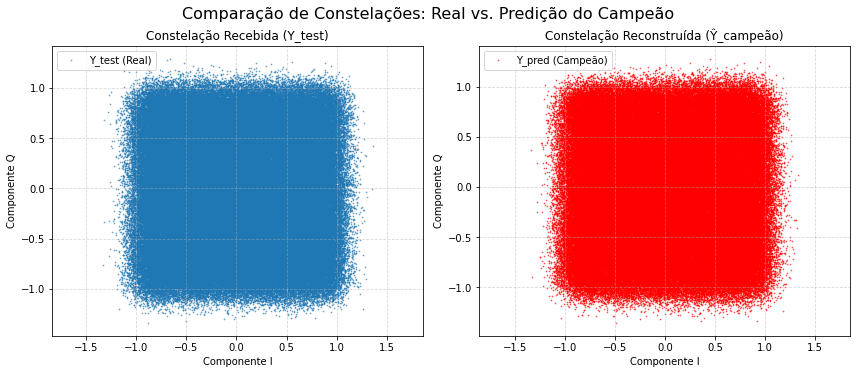

Plot de histogramas de ruído salvo em: /workspace/2-Training_Codes_Jupyter/logs_runs/campeao_histogramas_ruido_plot.png


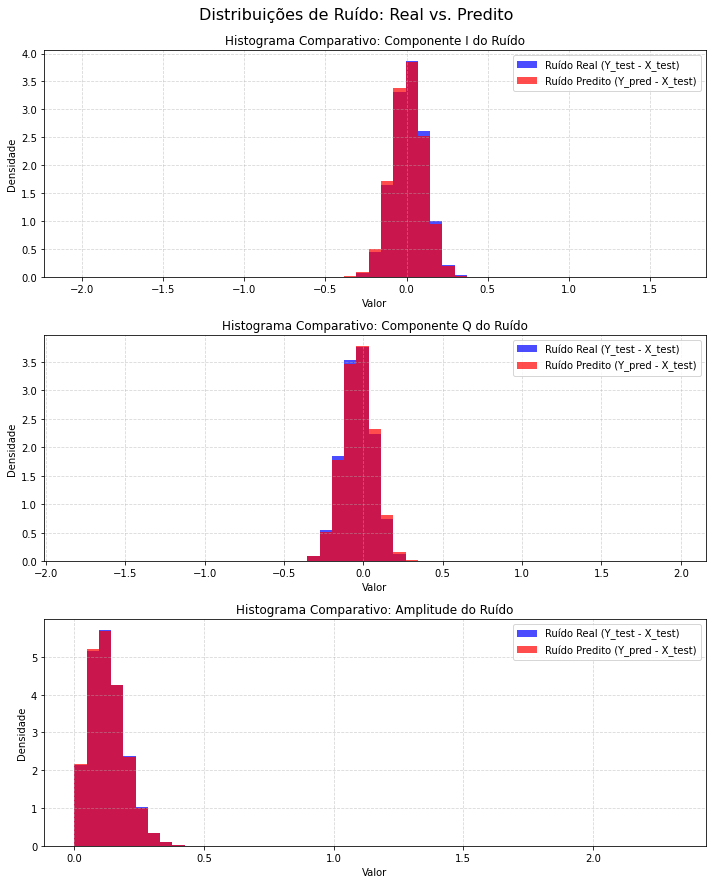

Plot Q-Q salvo em: /workspace/2-Training_Codes_Jupyter/logs_runs/campeao_qq_plot.png


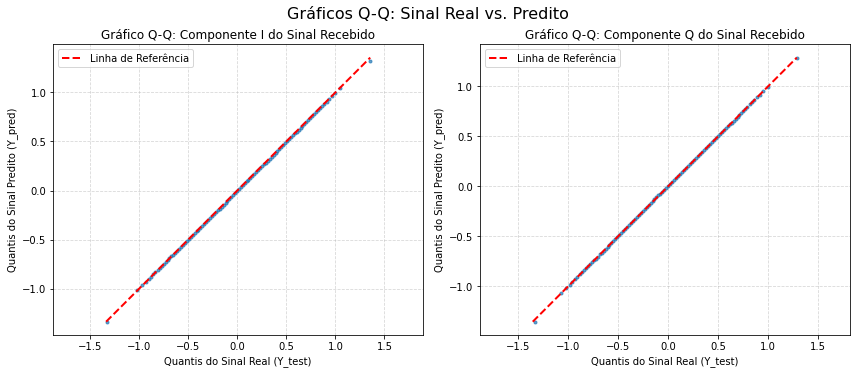

Plot da curva de transferência salvo em: /workspace/2-Training_Codes_Jupyter/logs_runs/campeao_curva_transferencia_plot.png


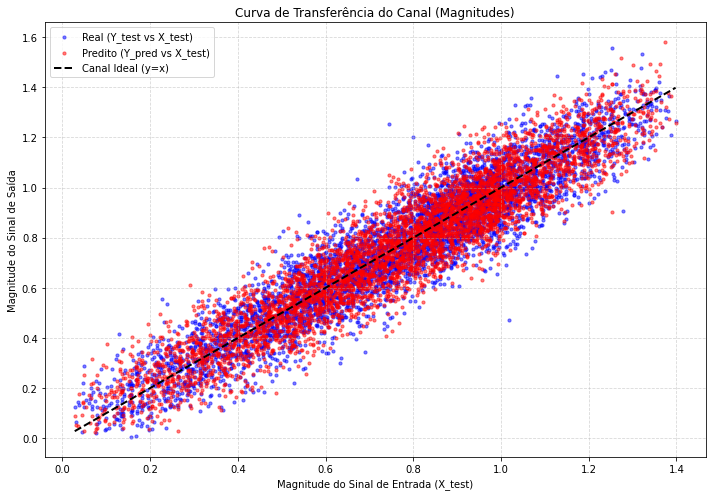

Plot do mapa de vetores de erro salvo em: /workspace/2-Training_Codes_Jupyter/logs_runs/campeao_mapa_vetores_erro_plot.png


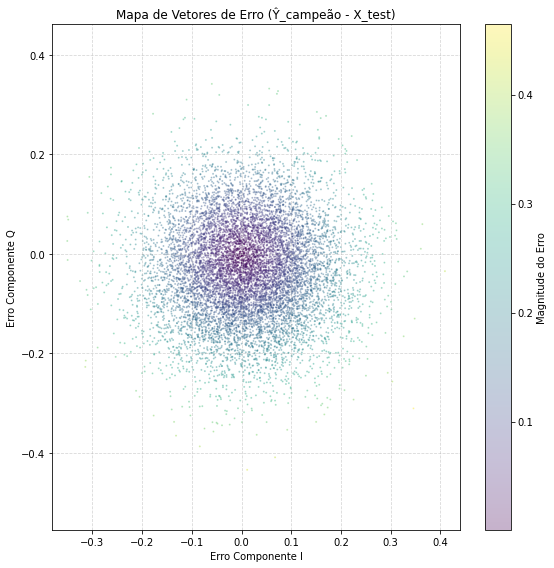


🏆  MÉTRICAS DO MODELO CAMPEÃO  🏆
Hiperparâmetros:
  layer1: 128
  layer2: 256
  layer3: 512
  latent_dim: 64
  beta: 0.58
  batch_size: 10000
  learning_rate: 0.0001
  activation: leaky_relu
MÉTRICAS DE RECONSTRUÇÃO:
  EVM (Ŷ vs X_test)          : 17.74% (-15.02 dB)
  SNR (Ŷ vs X_test)          : 15.02 dB
  RMSE (Ŷ vs X_test)         : 0.1448
  MSE (Ŷ vs X_test)          : 0.0210
  MAE (Ŷ vs X_test)          : 0.1283
  PSNR (Ŷ vs X_test)         : 16.79 dB
  Similaridade Cosseno        : 0.9842
  Correlação                  : 0.9844

MÉTRICAS DE DISTRIBUIÇÃO:
  KL Divergence (Y_test||Ŷ)  : 0.0004
  Jensen-Shannon Div. (Y,Ŷ)  : 0.0001

TESTE KOLMOGOROV-SMIRNOV (Y_test vs Ŷ):
  Componente I - Estatística  : 0.0042 (p-valor: 0.0815)
  Componente Q - Estatística  : 0.0038 (p-valor: 0.1398)
  Amplitude Sinal - Estatística: 0.0030 (p-valor: 0.3791)
  Amplitude Ruído - Estatística: 0.0043 (p-valor: 0.0705)
Score final do modelo campeão: 0.0000
Tempo de treinamento: 39.34 segundos
Épocas trei

In [2]:


# ────────────────────────────────────────────────────────────────────────
# 7)  RETREINA E SALVA O MODELO CAMPEÃO
# ────────────────────────────────────────────────────────────────────────
print("\nRetreinando o modelo campeão...")

# Selecionar os parâmetros do melhor modelo
best_params = {k: best_model[k] for k in param_grid.keys() if k in best_model.index}

# Construir o modelo campeão
vae_best, beta_cb_champion = build_conditional_vae(
    layer_sizes=[int(best_params['layer1']), int(best_params['layer2']), int(best_params['layer3'])],
    latent_dim=int(best_params['latent_dim']),
    activation=best_params['activation'],
    beta=float(best_params['beta']),
    learning_rate=float(best_params['learning_rate'])
)

# Configurar treinamento do campeão
epochs_champion_retrain = int(best_model['epochs'])
batch_size_champion_retrain = int(best_params['batch_size'])

print(f"Retreinando por {epochs_champion_retrain} épocas com batch_size {batch_size_champion_retrain}")

# Treinar o modelo campeão
history_champion = vae_best.fit(
    [X_train, Y_train], Y_train,
    epochs=epochs_champion_retrain,
    batch_size=batch_size_champion_retrain,
    callbacks=[beta_cb_champion],
    verbose=1
)

# Gerar predições finais
Y_pred_final_champion = vae_best.predict(
    [X_test, Y_test],
    batch_size=batch_size_champion_retrain,
    verbose=0
)
Y_pred_final_champion = Y_pred_final_champion[:Y_test.shape[0]]

# Salvar o modelo campeão
modelo_escolhido = "cvae_campeao_exported"
saved_model_path = os.path.join(logs_base_dir, modelo_escolhido)

try:
    vae_best.export(saved_model_path)
    print(f"Modelo campeão exportado com sucesso em: {saved_model_path}")
except Exception as e_export:
    print(f"Erro ao exportar o modelo campeão ({saved_model_path}): {e_export}")
    modelo_escolhido_keras = "cvae_campeao.keras"
    saved_model_keras_path = os.path.join(logs_base_dir, modelo_escolhido_keras)
    try:
        vae_best.save(saved_model_keras_path)
        print(f"Modelo campeão salvo como fallback no formato.keras em: {saved_model_keras_path}")
    except Exception as e_keras_save:
        print(f"Erro ao salvar modelo campeão como.keras ({saved_model_keras_path}): {e_keras_save}")

# ────────────────────────────────────────────────────────────────────────
# 8)  PLOTS E MÉTRICAS DO CAMPEÃO
# ────────────────────────────────────────────────────────────────────────
print("\nGerando análises visuais e métricas para o modelo campeão...")

# Converter dados para CPU para plotagem
if gpu_enabled:
    y_test_cpu = cp.asnumpy(Y_test) if isinstance(Y_test, cp.ndarray) else Y_test
    y_pred_final_champion_cpu = cp.asnumpy(Y_pred_final_champion) if isinstance(Y_pred_final_champion, cp.ndarray) else Y_pred_final_champion
    x_test_cpu = cp.asnumpy(X_test) if isinstance(X_test, cp.ndarray) else X_test
else:
    y_test_cpu = Y_test
    y_pred_final_champion_cpu = Y_pred_final_champion
    x_test_cpu = X_test

# --- 8.1 Constelações ---
fig_const, ax_const = plt.subplots(1, 2, figsize=(12, 5))

ax_const[0].scatter(y_test_cpu[:,0], y_test_cpu[:,1], s=0.5, alpha=0.6, label="Y_test (Real)")
ax_const[0].set_title("Constelação Recebida (Y_test)")
ax_const[0].set_xlabel("Componente I")
ax_const[0].set_ylabel("Componente Q")
ax_const[0].axis('equal')
ax_const[0].grid(True, linestyle='--', alpha=0.5)
ax_const[0].legend()

ax_const[1].scatter(y_pred_final_champion_cpu[:,0], y_pred_final_champion_cpu[:,1], s=0.5, alpha=0.6, color='red', label="Y_pred (Campeão)")
ax_const[1].set_title("Constelação Reconstruída (Ŷ_campeão)")
ax_const[1].set_xlabel("Componente I")
ax_const[1].set_ylabel("Componente Q")
ax_const[1].axis('equal')
ax_const[1].grid(True, linestyle='--', alpha=0.5)
ax_const[1].legend()

plt.tight_layout()
plt.suptitle("Comparação de Constelações: Real vs. Predição do Campeão", fontsize=16, y=1.03)
plot_save_path_const = os.path.join(logs_base_dir, "campeao_constelacao_plot.png")
plt.savefig(plot_save_path_const, dpi=300, bbox_inches='tight')
print(f"Plot de constelações salvo em: {plot_save_path_const}")
plt.show()

# --- 8.2 Análise de Distribuições de Ruído ---
noise_real = y_test_cpu - x_test_cpu
noise_pred = y_pred_final_champion_cpu - x_test_cpu

noise_real_I = noise_real[:,0]
noise_real_Q = noise_real[:,1]
noise_real_Amp = np.sqrt(noise_real_I**2 + noise_real_Q**2)

noise_pred_I = noise_pred[:,0]
noise_pred_Q = noise_pred[:,1]
noise_pred_Amp = np.sqrt(noise_pred_I**2 + noise_pred_Q**2)

data_to_plot_noise = [
    (noise_real_I, noise_pred_I, 'Componente I do Ruído'),
    (noise_real_Q, noise_pred_Q, 'Componente Q do Ruído'),
    (noise_real_Amp, noise_pred_Amp, 'Amplitude do Ruído')
]

fig_hist_noise, axes_hist_noise = plt.subplots(len(data_to_plot_noise), 1, figsize=(10, 4 * len(data_to_plot_noise)))
if len(data_to_plot_noise) == 1:
    axes_hist_noise = [axes_hist_noise]

for i, (data_r, data_p, title_suffix) in enumerate(data_to_plot_noise):
    min_val = min(np.min(data_r), np.min(data_p))
    max_val = max(np.max(data_r), np.max(data_p))
    bins = np.linspace(min_val, max_val, 50)

    axes_hist_noise[i].hist(data_r, bins=bins, alpha=0.7, label='Ruído Real (Y_test - X_test)', color='blue', density=True)
    axes_hist_noise[i].hist(data_p, bins=bins, alpha=0.7, label='Ruído Predito (Y_pred - X_test)', color='red', density=True)
    axes_hist_noise[i].set_title(f'Histograma Comparativo: {title_suffix}')
    axes_hist_noise[i].set_xlabel('Valor')
    axes_hist_noise[i].set_ylabel('Densidade')
    axes_hist_noise[i].legend()
    axes_hist_noise[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Distribuições de Ruído: Real vs. Predito", fontsize=16, y=1.02)
plot_save_path_hist_noise = os.path.join(logs_base_dir, "campeao_histogramas_ruido_plot.png")
plt.savefig(plot_save_path_hist_noise, dpi=300, bbox_inches='tight')
print(f"Plot de histogramas de ruído salvo em: {plot_save_path_hist_noise}")
plt.show()

# --- 8.3 Gráficos Q-Q (Quantil-Quantil) ---
data_to_qq_signal = [
    (y_test_cpu[:,0], y_pred_final_champion_cpu[:,0], 'Componente I do Sinal Recebido'),
    (y_test_cpu[:,1], y_pred_final_champion_cpu[:,1], 'Componente Q do Sinal Recebido'),
]

fig_qq, axes_qq = plt.subplots(1, len(data_to_qq_signal), figsize=(6 * len(data_to_qq_signal), 5))
if len(data_to_qq_signal) == 1:
    axes_qq = [axes_qq]

for i, (data_r, data_p, title_suffix) in enumerate(data_to_qq_signal):
    quantiles = np.linspace(0, 100, 101)
    qn_r = np.percentile(data_r, quantiles)
    qn_p = np.percentile(data_p, quantiles)

    axes_qq[i].plot(qn_r, qn_p, 'o', markersize=3, alpha=0.7)
    min_val_qq = min(np.min(qn_r), np.min(qn_p))
    max_val_qq = max(np.max(qn_r), np.max(qn_p))
    axes_qq[i].plot([min_val_qq, max_val_qq], [min_val_qq, max_val_qq], 'r--', lw=2, label='Linha de Referência')
    axes_qq[i].set_xlabel('Quantis do Sinal Real (Y_test)')
    axes_qq[i].set_ylabel('Quantis do Sinal Predito (Y_pred)')
    axes_qq[i].set_title(f'Gráfico Q-Q: {title_suffix}')
    axes_qq[i].axis('equal')
    axes_qq[i].grid(True, linestyle='--', alpha=0.5)
    axes_qq[i].legend()

plt.tight_layout()
plt.suptitle("Gráficos Q-Q: Sinal Real vs. Predito", fontsize=16, y=1.03)
plot_save_path_qq = os.path.join(logs_base_dir, "campeao_qq_plot.png")
plt.savefig(plot_save_path_qq, dpi=300, bbox_inches='tight')
print(f"Plot Q-Q salvo em: {plot_save_path_qq}")
plt.show()

# --- 8.4 Curva de Transferência do Canal (Magnitude) ---
mag_X_test = np.sqrt(x_test_cpu[:,0]**2 + x_test_cpu[:,1]**2)
mag_Y_test = np.sqrt(y_test_cpu[:,0]**2 + y_test_cpu[:,1]**2)
mag_Y_pred = np.sqrt(y_pred_final_champion_cpu[:,0]**2 + y_pred_final_champion_cpu[:,1]**2)

# Amostragem para visualização
sample_size = min(5000, len(mag_X_test))
sample_indices = np.random.choice(len(mag_X_test), size=sample_size, replace=False)

fig_transfer, ax_transfer = plt.subplots(1, 1, figsize=(10, 7))
ax_transfer.scatter(mag_X_test[sample_indices], mag_Y_test[sample_indices],
                   alpha=0.5, s=10, label='Real (Y_test vs X_test)', color='blue')
ax_transfer.scatter(mag_X_test[sample_indices], mag_Y_pred[sample_indices],
                   alpha=0.5, s=10, label='Predito (Y_pred vs X_test)', color='red')

# Linha de referência (canal ideal)
min_mag, max_mag = np.min(mag_X_test[sample_indices]), np.max(mag_X_test[sample_indices])
ax_transfer.plot([min_mag, max_mag], [min_mag, max_mag], 'k--', lw=2, label='Canal Ideal (y=x)')

ax_transfer.set_xlabel('Magnitude do Sinal de Entrada (X_test)')
ax_transfer.set_ylabel('Magnitude do Sinal de Saída')
ax_transfer.set_title('Curva de Transferência do Canal (Magnitudes)')
ax_transfer.legend()
ax_transfer.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plot_save_path_transfer = os.path.join(logs_base_dir, "campeao_curva_transferencia_plot.png")
plt.savefig(plot_save_path_transfer, dpi=300, bbox_inches='tight')
print(f"Plot da curva de transferência salvo em: {plot_save_path_transfer}")
plt.show()

# --- 8.5 Mapa de Vetores de Erro ---
error_vectors = y_pred_final_champion_cpu - x_test_cpu
sample_indices_ev = np.random.choice(len(error_vectors), size=min(10000, len(error_vectors)), replace=False)

fig_err_vec, ax_err_vec = plt.subplots(1, 1, figsize=(8, 8))
scatter = ax_err_vec.scatter(error_vectors[sample_indices_ev, 0], error_vectors[sample_indices_ev, 1],
                           s=1, alpha=0.3, c=np.sqrt(error_vectors[sample_indices_ev, 0]**2 + error_vectors[sample_indices_ev, 1]**2),
                           cmap='viridis')
ax_err_vec.set_title('Mapa de Vetores de Erro (Ŷ_campeão - X_test)')
ax_err_vec.set_xlabel('Erro Componente I')
ax_err_vec.set_ylabel('Erro Componente Q')
ax_err_vec.axis('equal')
ax_err_vec.grid(True, linestyle='--', alpha=0.5)

# Adicionar colorbar
plt.colorbar(scatter, ax=ax_err_vec, label='Magnitude do Erro')

plt.tight_layout()
plot_save_path_err_vec = os.path.join(logs_base_dir, "campeao_mapa_vetores_erro_plot.png")
plt.savefig(plot_save_path_err_vec, dpi=300, bbox_inches='tight')
print(f"Plot do mapa de vetores de erro salvo em: {plot_save_path_err_vec}")
plt.show()

# --- 8.6 Métricas Finais do Campeão ---
print("\n🏆  MÉTRICAS DO MODELO CAMPEÃO  🏆")
print("=" * 50)
print("Hiperparâmetros:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print("=" * 50)

# Calcular métricas finais
evm_pct_champ, evm_db_champ = calculate_evm(X_test, Y_pred_final_champion)
snr_db_champ = calculate_snr(X_test, Y_pred_final_champion)
kl_final_champ = calculate_kl_gpu(Y_test, Y_pred_final_champion)
jsd_final_champ = calculate_jsd_gpu(Y_test, Y_pred_final_champion)
mse_final_champ, rmse_final_champ, mae_final_champ, cos_sim_champ, corr_champ = compute_basic_metrics(X_test, Y_pred_final_champion)
psnr_final_champ = calculate_psnr(mse_final_champ)

# Testes Kolmogorov-Smirnov
ks_stat_I, p_value_I = calculate_ks_test(y_test_cpu[:,0], y_pred_final_champion_cpu[:,0])
ks_stat_Q, p_value_Q = calculate_ks_test(y_test_cpu[:,1], y_pred_final_champion_cpu[:,1])
ks_stat_Amp, p_value_Amp = calculate_ks_test(mag_Y_test, mag_Y_pred)
ks_stat_Noise_Amp, p_value_Noise_Amp = calculate_ks_test(noise_real_Amp, noise_pred_Amp)

# Exibir métricas
print(f"MÉTRICAS DE RECONSTRUÇÃO:")
print(f"  EVM (Ŷ vs X_test)          : {evm_pct_champ:.2f}% ({evm_db_champ:.2f} dB)")
print(f"  SNR (Ŷ vs X_test)          : {snr_db_champ:.2f} dB")
print(f"  RMSE (Ŷ vs X_test)         : {rmse_final_champ:.4f}")
print(f"  MSE (Ŷ vs X_test)          : {mse_final_champ:.4f}")
print(f"  MAE (Ŷ vs X_test)          : {mae_final_champ:.4f}")
print(f"  PSNR (Ŷ vs X_test)         : {psnr_final_champ:.2f} dB")
print(f"  Similaridade Cosseno        : {cos_sim_champ:.4f}")
print(f"  Correlação                  : {corr_champ:.4f}")

print(f"\nMÉTRICAS DE DISTRIBUIÇÃO:")
print(f"  KL Divergence (Y_test||Ŷ)  : {kl_final_champ:.4f}")
print(f"  Jensen-Shannon Div. (Y,Ŷ)  : {jsd_final_champ:.4f}")

print(f"\nTESTE KOLMOGOROV-SMIRNOV (Y_test vs Ŷ):")
print(f"  Componente I - Estatística  : {ks_stat_I:.4f} (p-valor: {p_value_I:.4f})")
print(f"  Componente Q - Estatística  : {ks_stat_Q:.4f} (p-valor: {p_value_Q:.4f})")
print(f"  Amplitude Sinal - Estatística: {ks_stat_Amp:.4f} (p-valor: {p_value_Amp:.4f})")
print(f"  Amplitude Ruído - Estatística: {ks_stat_Noise_Amp:.4f} (p-valor: {p_value_Noise_Amp:.4f})")

print("=" * 50)
print(f"Score final do modelo campeão: {best_model['score']:.4f}")
print(f"Tempo de treinamento: {best_model['duration_sec']:.2f} segundos")
print(f"Épocas treinadas: {best_model['epochs']}")
print("=" * 50)

# --- 8.7 Salvar Resumo das Métricas ---
metrics_summary = {
    'model_score': best_model['score'],
    'hyperparameters': best_params,
    'reconstruction_metrics': {
        'evm_percent': evm_pct_champ,
        'evm_db': evm_db_champ,
        'snr_db': snr_db_champ,
        'rmse': rmse_final_champ,
        'mse': mse_final_champ,
        'mae': mae_final_champ,
        'psnr_db': psnr_final_champ,
        'cosine_similarity': cos_sim_champ,
        'correlation': corr_champ
    },
    'distribution_metrics': {
        'kl_divergence': kl_final_champ,
        'jsd': jsd_final_champ
    },
    'ks_tests': {
        'component_I': {'statistic': ks_stat_I, 'p_value': p_value_I},
        'component_Q': {'statistic': ks_stat_Q, 'p_value': p_value_Q},
        'signal_amplitude': {'statistic': ks_stat_Amp, 'p_value': p_value_Amp},
        'noise_amplitude': {'statistic': ks_stat_Noise_Amp, 'p_value': p_value_Noise_Amp}
    },
    'training_info': {
        'epochs': int(best_model['epochs']),
        'duration_sec': float(best_model['duration_sec']),
        'timestamp': best_model['timestamp']
    }
}

# Salvar resumo em JSON
import json
summary_path = os.path.join(logs_base_dir, "champion_model_summary.json")
with open(summary_path, 'w') as f:
    json.dump(metrics_summary, f, indent=2, default=str)
print(f"Resumo das métricas salvo em: {summary_path}")

print("\n🎯 ANÁLISE DO MODELO CAMPEÃO CONCLUÍDA! 🎯")
print(f"Todos os plots e métricas foram salvos em: {logs_base_dir}")

### MÉTRICAS ABSOLUTAS ###


,evm_pct,snr_db,mse,rmse,mae,cosim,corr
Real,18.12138,14.83618,0.02187,0.14788,0.12924,0.98358,0.98373
CVAE,18.20288,14.79720,0.02206,0.14854,0.13164,0.98337,0.98355
AWGN,25.63709,11.82262,0.04377,0.20921,0.18536,0.96869,0.96869



### Δ versus REAL  (positivo = melhor) ###


,evm_pct,snr_db,mse,rmse,mae,cosim,corr
CVAE_vs_Real,-0.08150,-0.03898,-0.00020,-0.00067,-0.00240,-0.00021,-0.00018
AWGN_vs_Real,-7.51571,-3.01355,-0.02190,-0.06133,-0.05613,-0.01489,-0.01504


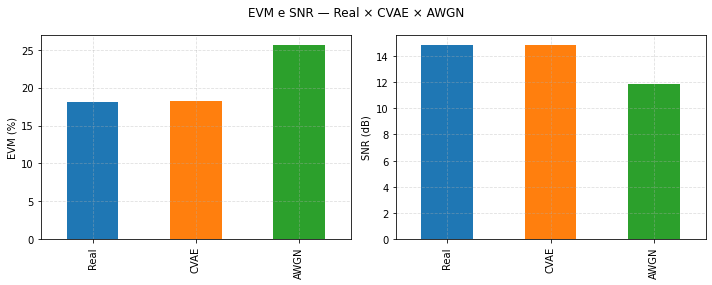

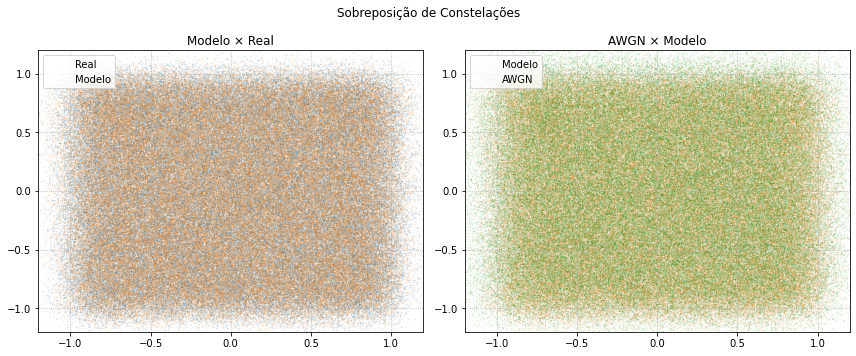

In [3]:
# =============================================================================
#  🔰 BLOCO FINAL — COMPARAÇÃO COMPLETA  (Real × CVAE × AWGN)
#     pré-requisitos no namespace:
#        X_test  : sinal enviado (N,2)   ─  normalizado
#        Y_test  : sinal recebido real   ─  normalizado
#        Y_pred  : sinal reconstruído pelo CVAE
#        Funções : calculate_noise_power, calculate_evm, calculate_snr
# =============================================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 1 ▸ GERAR O BASÉLINE AWGN  (mesma potência de ruído do canal real)
# ─────────────────────────────────────────────────────────────────────────────
noise_power_real = calculate_noise_power(X_test, Y_test)      # σ²_real
sigma            = np.sqrt(noise_power_real)                  # desvio-padrão
rng              = np.random.default_rng(seed=42)             # reprodutível
noise            = rng.normal(0.0, sigma, size=X_test.shape)  # AWGN complexo I/Q
Y_awgn           = X_test + noise                             # saída AWGN

# ─────────────────────────────────────────────────────────────────────────────
# 2 ▸ FUNÇÃO DE MÉTRICAS (coerente com compute_basic_metrics do pdf)
# ─────────────────────────────────────────────────────────────────────────────
def _all_metrics(ref, est):
    diff = ref - est
    mse  = np.mean(np.sum(diff**2, axis=1))       # ‖erro‖² médio
    rmse = np.sqrt(mse)
    mae  = np.mean(np.linalg.norm(diff, axis=1))  # ‖erro‖ médio (norma-L2)
    flat_r, flat_e = ref.ravel(), est.ravel()
    cosim = np.dot(flat_r, flat_e) / (np.linalg.norm(flat_r)*np.linalg.norm(flat_e))
    corr  = np.corrcoef(flat_r, flat_e)[0, 1]
    evm_pct, _ = calculate_evm(ref, est)
    snr_db     = calculate_snr(ref, est)
    return dict(evm_pct=evm_pct, snr_db=snr_db,
                mse=mse, rmse=rmse, mae=mae,
                cosim=cosim, corr=corr)

# ─────────────────────────────────────────────────────────────────────────────
# 3 ▸ MÉTRICAS ABSOLUTAS  (DataFrame results)
# ─────────────────────────────────────────────────────────────────────────────
results = pd.DataFrame.from_dict({
    'Real' : _all_metrics(X_test, Y_test),
    'CVAE' : _all_metrics(X_test, Y_pred),
    'AWGN' : _all_metrics(X_test, Y_awgn),
}).T

# ─────────────────────────────────────────────────────────────────────────────
# 4 ▸ Δ vs REAL   (positivo = melhora sobre o canal real)
# ─────────────────────────────────────────────────────────────────────────────
err_metrics  = ['evm_pct','mse','rmse','mae']        # menor → melhor
qual_metrics = ['snr_db','cosim','corr']             # maior → melhor

delta_vs_real = pd.DataFrame(index=['CVAE_vs_Real','AWGN_vs_Real'],
                             columns=results.columns, dtype=float)

for m in results.columns:
    real_val = results.loc['Real', m]
    for tag, other in [('CVAE_vs_Real','CVAE'), ('AWGN_vs_Real','AWGN')]:
        other_val = results.loc[other, m]
        if m in err_metrics:
            delta_vs_real.loc[tag, m] = real_val - other_val
        else:  # qualidade
            delta_vs_real.loc[tag, m] = other_val - real_val

# ─────────────────────────────────────────────────────────────────────────────
# 5 ▸ SALVAR / EXIBIR TABELAS
# ─────────────────────────────────────────────────────────────────────────────
results.to_csv('metrics_comparison.csv')
delta_vs_real.to_csv('delta_vs_real.csv')

print("### MÉTRICAS ABSOLUTAS ###")
display(results.style.format("{:.5f}"))
print("\n### Δ versus REAL  (positivo = melhor) ###")
display(delta_vs_real.style.format("{:+.5f}"))

# ─────────────────────────────────────────────────────────────────────────────
# 6 ▸ GRÁFICO EVM & SNR  (Real × CVAE × AWGN)
# ─────────────────────────────────────────────────────────────────────────────
fig1, ax = plt.subplots(1, 2, figsize=(10, 4))
results['evm_pct'].plot.bar(ax=ax[0], color=['tab:blue','tab:orange','tab:green'])
ax[0].set_ylabel('EVM (%)'); ax[0].grid(ls='--', alpha=.4)
results['snr_db'].plot.bar(ax=ax[1], color=['tab:blue','tab:orange','tab:green'])
ax[1].set_ylabel('SNR (dB)'); ax[1].grid(ls='--', alpha=.4)
fig1.suptitle('EVM e SNR — Real × CVAE × AWGN', fontsize=12)
fig1.tight_layout(); fig1.savefig('evm_snr_comparison.png', dpi=300, bbox_inches='tight')

# ─────────────────────────────────────────────────────────────────────────────
# 7 ▸ SOBREPOSIÇÃO DE CONSTELAÇÕES
# ─────────────────────────────────────────────────────────────────────────────
lim    = (-1.2, 1.2)
sample = min(150_000, len(X_test))
idx    = np.random.choice(len(X_test), sample, replace=False)

fig2, axs = plt.subplots(1, 2, figsize=(12, 5))

# A) Real × Modelo
axs[0].scatter(Y_test[idx,0], Y_test[idx,1], s=.15, alpha=.15, label='Real',   color='tab:blue')
axs[0].scatter(Y_pred[idx,0], Y_pred[idx,1], s=.15, alpha=.15, label='Modelo', color='tab:orange')
axs[0].set_title('Modelo × Real'); axs[0].set_xlim(lim); axs[0].set_ylim(lim)
axs[0].grid(True, ls=':'); axs[0].legend()

# B) AWGN × Modelo
axs[1].scatter(Y_pred[idx,0], Y_pred[idx,1], s=.15, alpha=.15, label='Modelo', color='tab:orange')
axs[1].scatter(Y_awgn[idx,0], Y_awgn[idx,1], s=.15, alpha=.15, label='AWGN',   color='tab:green')
axs[1].set_title('AWGN × Modelo'); axs[1].set_xlim(lim); axs[1].set_ylim(lim)
axs[1].grid(True, ls=':'); axs[1].legend()

fig2.suptitle('Sobreposição de Constelações', fontsize=12)
fig2.tight_layout(); fig2.savefig('overlap_constellations.png', dpi=300, bbox_inches='tight')
